# Are some features responsibles for encoding synonymy ?

In [73]:
import sklearn

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import graphviz
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from random import shuffle

import gensim

from gensim.models import KeyedVectors

import nltk

from nltk.corpus import wordnet as wn

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/olivier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#get infos in wordnet
def get_wornet_synonyms_hypernyms(noun, words_filter=None):
    """Return le list of hypernyms and hyponyms of a word from wordvec.
    
    :param noun: the noun to find some synonyms
    :param words_filter: a list, if not None, return only words contained in this list

    :type noun: str
    :type words_filter: list(str)

    :return: a list of synonyms 
    :rtype: list(str)
    """
    try:
        hypernyms = wn.synsets(noun)[0].hypernyms()[0].lemma_names() #NB: on ne prend que le premier
    except:
        hypernyms = []
    try:
        hyponyms = wn.synsets(noun)[0].hyponyms()[0].lemma_names() #NB: on ne prend que le premier
    except:
        hyponyms = []
    if words_filter:
        out = []
        for w in hypernyms + hyponyms:
            if w in words_filter:
                out.append(w)
        return out
    return hypernyms + hyponyms

def get_wornet_synonyms(noun, words_filter=None):
    """Return le list of synonyms of a word from wordvec.
    
    :param noun: the noun to find some synonyms
    :param words_filter: a list, if not None, return only words contained in this list

    :type noun: str
    :type words_filter: list(str)

    :return: a list of synonyms 
    :rtype: list(str)
    """
    try:
        w = []
        for sn in wn.synsets(noun): 
            #TODO: check if the synset is a nouns synset and not verbs 
            #DONE: si on passe les mots qui sont des nomns seulemnt dans words_filter
            w.extend(sn.lemma_names())
    except:
        w = []
    w = list(set(w))
    return list(filter(lambda s: s in words_filter, w)) if words_filter else w



def similar_word2vec_words(word_vectors, noun, words_filter=None, n=10):
    """Return a list of the `n` most similar words from word2vec.
    
    :param word_vectors: the gensim word2vec model
    :param noun: the noun to find some similar words
    :param words_filter: a list, if not None, return only words contained in this list
    :param n: only return this number of words (max)

    :type word_vectors: gensim.models.keyedvectors.Word2VecKeyedVector
    :type noun: str
    :type words_filter: list(str)
    :type n: int
    
    :return: a list of similar meaning words
    :rtype: list(str)
    """
    tmp = list(list(zip(*word_vectors.similar_by_word(noun, n)))[0])
    if not words_filter:
        return tmp
    return list(filter(lambda s: s in words_filter, tmp))

def get_positive_and_negatives_synonyms_pairs(word_vectors, noun, words_filter=None, n=20):
    """Return 2 lists containing the synonyms int the first, 
    and similiars words in the second.
    
    :param word_vectors: the gensim word2vec model
    :param noun: the noun to find some similar words
    :param words_filter: a list, if not None, return only words contained in this list
    :param n: only return this number of words (max)
    
    :type word_vectors: gensim.models.keyedvectors.Word2VecKeyedVector
    :type noun: str
    :type words_filter: list(str)
    :type n: int
    
    :return: a tuple containg 2 lists: ([synonyms], [similars])
    :rtype: tuple(list(str), list(str))
    """
    synonyms = get_wornet_synonyms(noun, words_filter=words_filter)
    similars = similar_word2vec_words(word_vectors, noun, words_filter=words_filter)
    not_synonyms = list(filter(lambda s: not s in synonyms, similars))
    return synonyms, not_synonyms

#list all word2vec nouns exploitables
def is_exploitable(s):
    """not accept urls, names, patterns and weird stuffs... 
    AND is in wordnet database !!"""
    if s != s.lower():
        return False
    for c in '._+#/@':
        if c in s:
            return False
    #simple heuristic: remove all words ending with 's' to get only singular nouns
    if s[-1] == 's':
        return False
    if s.isalpha():
        return wn.synsets(s) != [] #check if is in wordnnet databse


In [3]:
try:
    positives = np.load("positives.npy")
    negatives = np.load("negatives.npy")
except:
    print("* load word2vec pretrained from google")
    word_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

    print("* load nouns")

    print(" - list all wordnet nouns")
    wordnet_nouns = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}

    print(" - build a list of exploitable words")
    words = list(filter(is_exploitable, word_vectors.index2word))
    words = list(filter(lambda s: s in wordnet_nouns, words))

    #example
    synonyms, not_synonyms = get_positive_and_negatives_synonyms_pairs(word_vectors, "dog", words)

    print("* build a dataset of synonyms / not synonyms")
    positives = []
    negatives = []

    allready_seen_words = [] #allow us to remove some simple duplicates

    shuffle(words)

    nb_max_words = len(words)

    print(" - build pairs")
    for word in tqdm(words[:nb_max_words]):
        if word in allready_seen_words:
            continue
        allready_seen_words.append(word)
        pos, neg = get_positive_and_negatives_synonyms_pairs(word_vectors, word, words)
        for p in pos:
            positives.append((word, p))
        for n in neg:
            negatives.append((word, n))

    np.save("positives", np.array(positives))
    np.save("negatives", np.array(negatives))

positives = list(positives)
negatives = list(negatives)

shuffle(positives)
shuffle(negatives)

positives = np.array(positives)
negatives = np.array(negatives)

In [4]:
positives, negatives

(array([['depository', 'deposit'],
        ['first', 'beginning'],
        ['dispersion', 'scattering'],
        ...,
        ['eddy', 'purl'],
        ['patch', 'while'],
        ['running', 'draw']], dtype='<U31'), array([['bolete', 'chanterelle'],
        ['aura', 'cachet'],
        ['griffon', 'borzoi'],
        ...,
        ['place', 'finish'],
        ['adelaide', 'sydney'],
        ['transcendence', 'profundity']], dtype='<U29'))

In [5]:
try:
    positive_embedings = np.load("positive_embedings.npy")
    negative_embedings = np.load("negative_embedings.npy")
except:
    print(" - compute embedings")
    positive_embedings = np.array(list(map(
        lambda c: [word_vectors.word_vec(c[0]), word_vectors.word_vec(c[1])], 
        positives
    )))

    negative_embedings = np.array(list(map(
        lambda c: [word_vectors.word_vec(c[0]), word_vectors.word_vec(c[1])], 
        negatives
    )))
    
    np.save("positive_embedings", positive_embedings)
    np.save("negative_embedings", negative_embedings)

positive_embedings = list(positive_embedings)
negative_embedings = list(negative_embedings)

shuffle(positive_embedings)
shuffle(negative_embedings)

positive_embedings = np.array(positive_embedings)
negative_embedings = np.array(negative_embedings)

In [6]:
#keep the same number of positive vs negatives
nb_max_rows = min(len(positives), len(negatives))

positive_train = positive_embedings[:int(nb_max_rows * .8)]
positive_test  = positive_embedings[int(nb_max_rows * .8):nb_max_rows]

negative_train = negative_embedings[:int(nb_max_rows * .8)]
negative_test  = negative_embedings[int(nb_max_rows * .8):nb_max_rows]

In [51]:
print(" - split dataset in training/test sets")
x_train = np.array(list(positive_train) + list(negative_train))
y_train = np.array([0] * len(positive_train) + [1] * len(negative_train)) #0 means synonym

x_test = np.array(list(positive_test) + list(negative_test))
y_test = np.array([0] * len(positive_test) + [1] * len(negative_test))

 - split dataset in training/test sets


In [52]:
print(" - augment the dataset by adding the symetry")
#adding a symetry to the dataset let us to augment data for free 
#and remove some noise (the anchor words is not allways on the same side...)
build_symetry = lambda x_set : np.array([x_set[:, 0, :], x_set[:, 1, :]]).swapaxes(0, 1)

assert (build_symetry(build_symetry(x_train)) == x_train).mean() == 1. #check the axis stuff

x_train = np.array(list(x_train) + list(build_symetry(x_train)))
x_test  = np.array(list(x_test)  + list(build_symetry(x_test)))

y_train = np.array(list(y_train) + list(y_train))
y_test  = np.array(list(y_test)  + list(y_test))

 - augment the dataset by adding the symetry


In [82]:
"""print(" - difference")
#substract w1 - w2 to get a difference of words to find if there is a dimension which encode synonymy
x_train = x_train[:, 0, :] - x_train[:, 1, :]
x_test  = x_test[:, 0, :]  - x_test[:, 1, :]
"""

print(" - cosine 'difference'")

#build a difference function inspired by the cosine distance
def diff(a, b):
    c = a * b
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return c / (norm_a * norm_b)

L = []
for i in trange(x_train.shape[0]):
    L.append(diff(x_train[i, 0, :], x_train[i, 1, :]))
x_train = np.array(L)

L = []
for i in trange(x_test.shape[0]):
    L.append(diff(x_test[i, 0, :], x_test[i, 1, :]))
x_test = np.array(L)

  4%|▍         | 5186/131104 [00:00<00:04, 26370.96it/s]

 - cosine 'difference'


100%|██████████| 32776/32776 [00:01<00:00, 25545.07it/s]


In [83]:
print(" - shuffle data")
data_train = list(zip(x_train, y_train))
data_test  = list(zip(x_test,  y_test))

shuffle(data_train)
shuffle(data_test)

x_train, y_train = list(zip(*data_train))
x_test,  y_test  = list(zip(*data_test))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test  = np.array(x_test)
y_test  = np.array(y_test)

 - shuffle data


## Train models and look what they learnt

In [92]:
#normalize features
mean, std = x_train.mean(0), x_train.std(0)
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

linear model
synonyms calssification accyracy :  66.76836709787649  %
[139 289 150   3 271   1  92  50 251 210 241  26 198  72 298  14  89  86
 272 277 279 105 212 152  76 117  65  45   0 218 171 200  62  57  39 167
 130 162 169  58 122  78 248 134 259 146  52  95  49 103  99 121 110 267
 164 114 247 286 161  36  10  32  81 282 172 109 170 124 296 151 107   5
  31 185 142  55  79 155 153 220 194 237  93  66 249 118  73 102 276 123
 132 137 148 138 195 236  28 285 125 222  83   9 287 275 230 243 211 136
   4  44 184  42 106 133  56 176  30  84 229  77 179  33 203 147 156 255
 168 208 192  98 270  22  46 207 214  82 297  90  60  69 115  24  38 204
 159 261 116 174  47 181 166 160  37 190 202  41 119  63 264 228 280 100
  64   2 183  87 101  97 284  75  88 233 177  29 242  25 235 252 141 149
  70  96 219  15 201  13 193 189 265  74 127 213 163 291 239  19 145 257
 104 281 158 232  12 186 244 269 221 154 178  53 180 144 157  67 187 288
 263 175 256 290 234 223 268 260  34  21  11  71 253 2

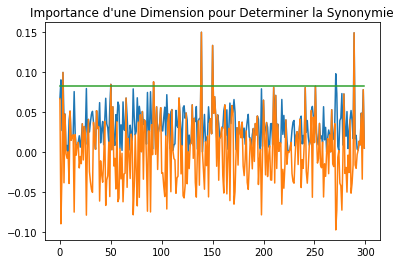

In [97]:
print("linear model")
clf = LogisticRegression(penalty='l1', C=0.05)
clf.fit(x_train, y_train)

acc = (clf.predict(x_test) == y_test).mean()
print("synonyms calssification accyracy : ", acc * 100, " %")

coefs = clf.coef_[0]

plt.title("Importance d'une Dimension pour Determiner la Synonymie")
plt.plot(abs(coefs))
plt.plot(coefs)

print(abs(coefs).argsort()[::-1])

#set a threshold
t = abs(coefs)
t = t.mean() + t.std() * 2
plt.plot([t] * len(coefs))

plt.show()

With a simple difference of words embedings (acc: 66.63%) the most important features are :
```
150 288 126 121 198
```
With the new difference function (acc: 66.76%) the most important features are :
```
139 289 150   3 271 
```

==> ___The 2 methods aggree on the importance of the feature `#150`...___


In [98]:
dt_clf = DecisionTreeClassifier(max_depth=3)
dt_clf.fit(x_train, y_train)

acc = (dt_clf.predict(x_test) == y_test).mean()
print("synonyms calssification accyracy : ", acc * 100, " %")

synonyms calssification accyracy :  64.07127166219185  %


In [99]:
def print_decision_tree(tree, feature_names=None, offset_unit='    '):
    '''Plots textual representation of rules of a decision tree
    tree: scikit-learn representation of tree
    feature_names: list of feature names. They are set to f1,f2,f3,... if not specified
    offset_unit: a string of offset of the conditional block'''

    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    value = tree.tree_.value
    if feature_names is None:
        features  = ['f%d'%i for i in tree.tree_.feature]
    else:
        features  = [feature_names[i] for i in tree.tree_.feature]        

    def recurse(left, right, threshold, features, node, depth=0):
            offset = offset_unit*depth
            if (threshold[node] != -2):
                    print(offset+"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
                    if left[node] != -1:
                            recurse (left, right, threshold, features,left[node],depth+1)
                    print(offset+"} else {")
                    if right[node] != -1:
                            recurse (left, right, threshold, features,right[node],depth+1)
                    print(offset+"}")
            else:
                    print(offset+"return " + str(value[node]))

    recurse(left, right, threshold, features, 0,0)

print_decision_tree(dt_clf)

if ( f243 <= -0.5065227746963501 ) {
    if ( f200 <= -0.20528116822242737 ) {
        if ( f52 <= 0.0011431040475144982 ) {
            return [[7546. 5948.]]
        } else {
            return [[1514. 3914.]]
        }
    } else {
        if ( f50 <= -0.7990960478782654 ) {
            return [[658. 536.]]
        } else {
            return [[2518. 8696.]]
        }
    }
} else {
    if ( f1 <= -0.44851624965667725 ) {
        if ( f52 <= -0.4518629312515259 ) {
            return [[5958. 5620.]]
        } else {
            return [[ 3962. 10004.]]
        }
    } else {
        if ( f86 <= -0.4249279201030731 ) {
            return [[ 5932. 10570.]]
        } else {
            return [[37464. 20264.]]
        }
    }
}


feature	importance
86	0.3136198697428081
1	0.21344922573890435
52	0.1870814650363096
243	0.14378949802624777
200	0.10850849491003327
50	0.033551446545696924


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


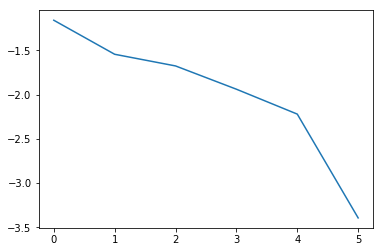

In [100]:
feature_importances = dt_clf.feature_importances_.argsort()[::-1]
print("feature\timportance")
for fi in feature_importances:
    t = dt_clf.feature_importances_[fi]
    if  t > 0:
        print(str(fi) + "\t" + str(t))
    else:
        break

plt.plot(np.log(sorted(dt_clf.feature_importances_)[::-1]))
plt.show()

The decision tree was __73.34%__ accurate with the simple embeddings difference and now only __64.07%__ accurate... 